### 1. Plotting the measurements with different fits

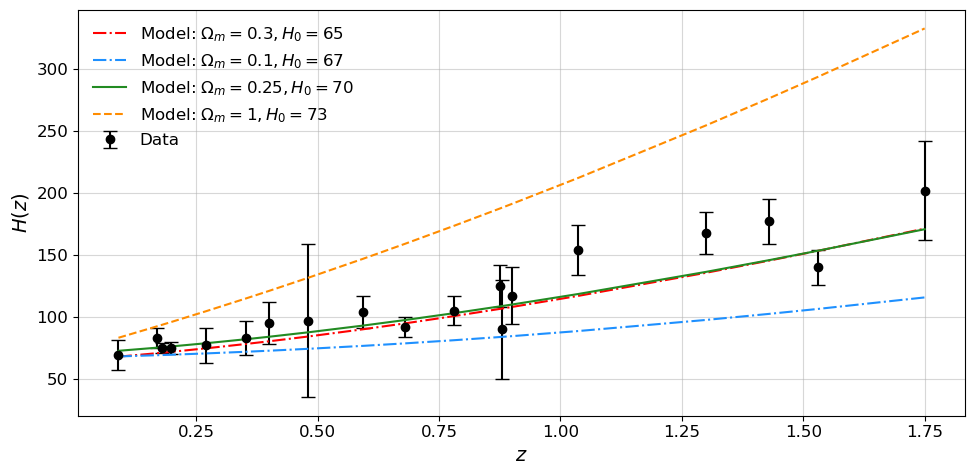

In [129]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import gaussian_kde
from matplotlib import rc

rc('font',**{'size':15,'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Loading the data from a file 'Hz_BC03_all.dat'
z, H, H_err = np.loadtxt('Hz_BC03_all.dat', unpack=True)

def H_model(z, H0, Om):
    value_under_sqrt = Om * (1 + z)**3 + (1 - Om)
    # Ensure that all values under the square root are non-negative
    if np.all(value_under_sqrt >= 0):
        return H0 * np.sqrt(value_under_sqrt)
    else:
        # Handle negative values
        raise ValueError("Negative value under square root")

# Plotting the model with diff parameters
plt.figure(figsize=(10, 5))
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'

# Plot data with error bars
plt.errorbar(z, H, H_err, c='black', ls='', fmt='o', label='Data', capsize=5)

# Plot model curves with different line styles and colors
plt.plot(z, H_model(z, 65, 0.3), c='red', ls='-.', label=r'Model: $\Omega_m = 0.3, H_0 = 65$')
plt.plot(z, H_model(z, 67, 0.1), c='dodgerblue', ls='-.', label=r'Model: $\Omega_m = 0.1, H_0 = 67$')
plt.plot(z, H_model(z, 70, 0.25), c='forestgreen', label=r'Model: $\Omega_m = 0.25, H_0 = 70$')
plt.plot(z, H_model(z, 73, 1), c='darkorange', ls='--', label=r'Model: $\Omega_m = 1, H_0 = 73$')

# Customize plot labels and ticks
plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$H(z)$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Customize legend
plt.legend(fontsize=12, loc='best', frameon=False)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()



### 2. Defining Posterior and Proposal Functions

In [131]:
# Defining a likelihood function
def likelihood(theta, z, H, H_err):
    H0, Om = theta
    model = H_model(z, H0, Om)
    return np.exp(-0.5 * np.sum((H - model)**2 / H_err**2))

# Defining a uniform prior
def prior(theta):
    H0, Om = theta
    if 50 < H0 < 100 and 0 < Om < 1:
        return 1.0  # Uniform prior
    return 0.0

# Defining a Posterior
def posterior(theta, z, H, H_err):
    return prior(theta) * likelihood(theta, z, H, H_err)

# Defining Proposal Distribution
NC, NB = 10**6, 10**5                # of MC samples, burn-in period
H_s1, Om_s2 = 1. , 0.03

prop_width = 1
def Proposal(d1, d2):                
    p1 = np.random.normal(d1, prop_width*H_s1)
    p2 = np.random.normal(d2, prop_width*Om_s2)
    return p1, p2

### 3. MCMC Code

In [133]:
def mcmc(): 
    chain = np.zeros((NC, 3))            # Initialize the chain, including pdf
    H1_0, Om2_0 = np.random.uniform(50,100), np.random.uniform(0.,1.)                 # 
    initial_c = H1_0, Om2_0
    chain[0] = H1_0, Om2_0, posterior(initial_c, z, H, H_err)

    count_accepted = 0                   # This is to keep track of how many accepted proposals we have

    for i in range(NC-1):                         # Fill the chain with MH sampling
        xstar1, xstar2 = Proposal(chain[i,0], chain[i,1])
        runtime_c = xstar1, xstar2
        pdfStar = posterior(runtime_c, z, H, H_err)
        ratio =  pdfStar / chain[i,2]
        if ratio >= 1:                            # Acceptance check
            chain[i+1] = xstar1, xstar2, pdfStar
            count_accepted += 1
        elif ratio > np.random.random():
            chain[i+1] = xstar1, xstar2, pdfStar
            count_accepted += 1
        else:
            chain[i+1] = chain[i]

    return chain, count_accepted

mcmc_chains = []
mcmc_chains_count_accepted = []

for i in range(5):
    chain, count_accepted = mcmc()
    mcmc_chains.append(chain)
    mcmc_chains_count_accepted.append(count_accepted)


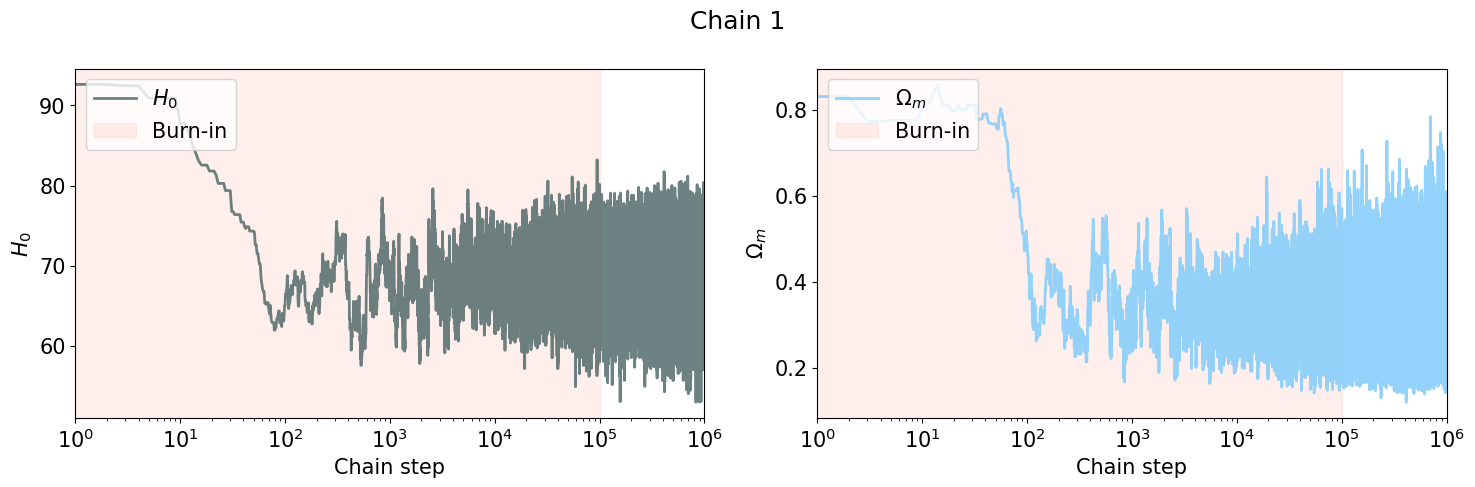

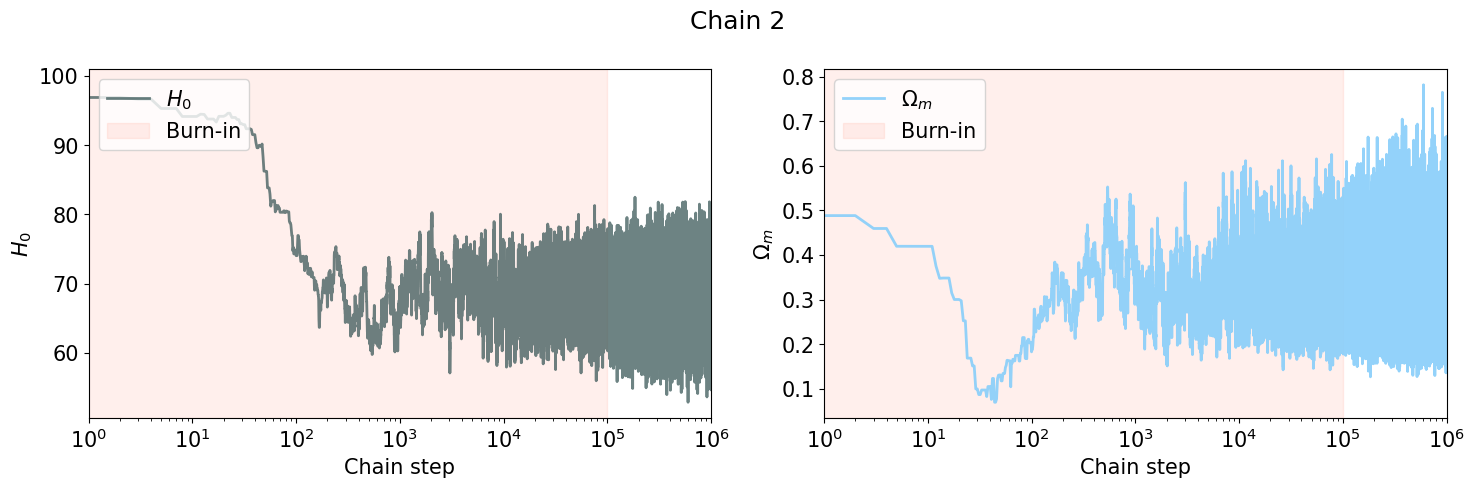

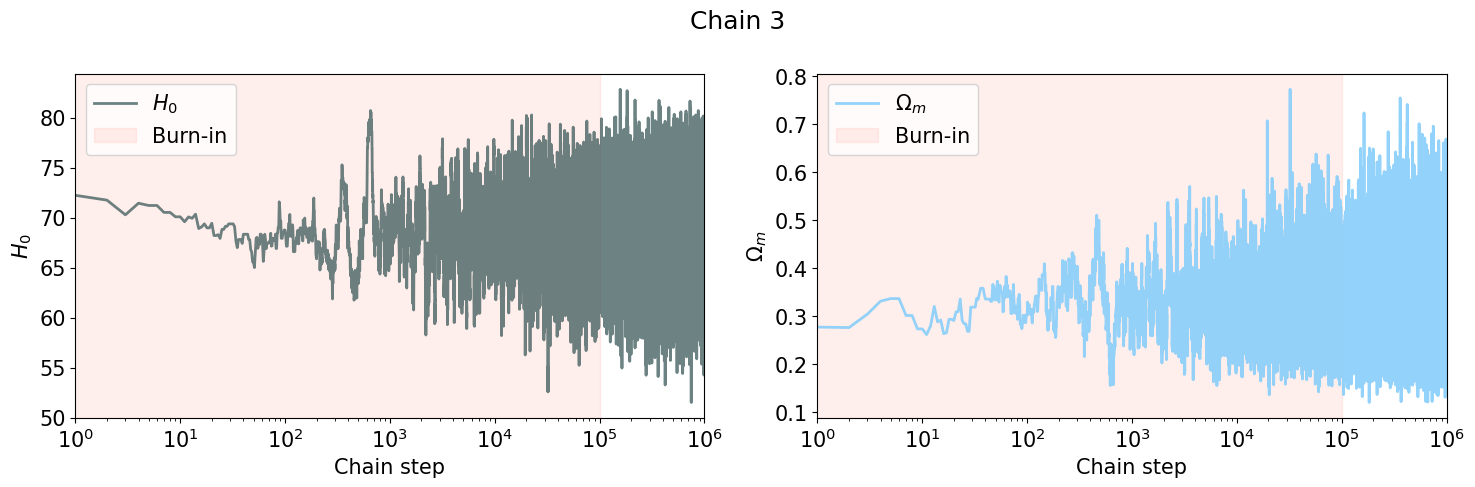

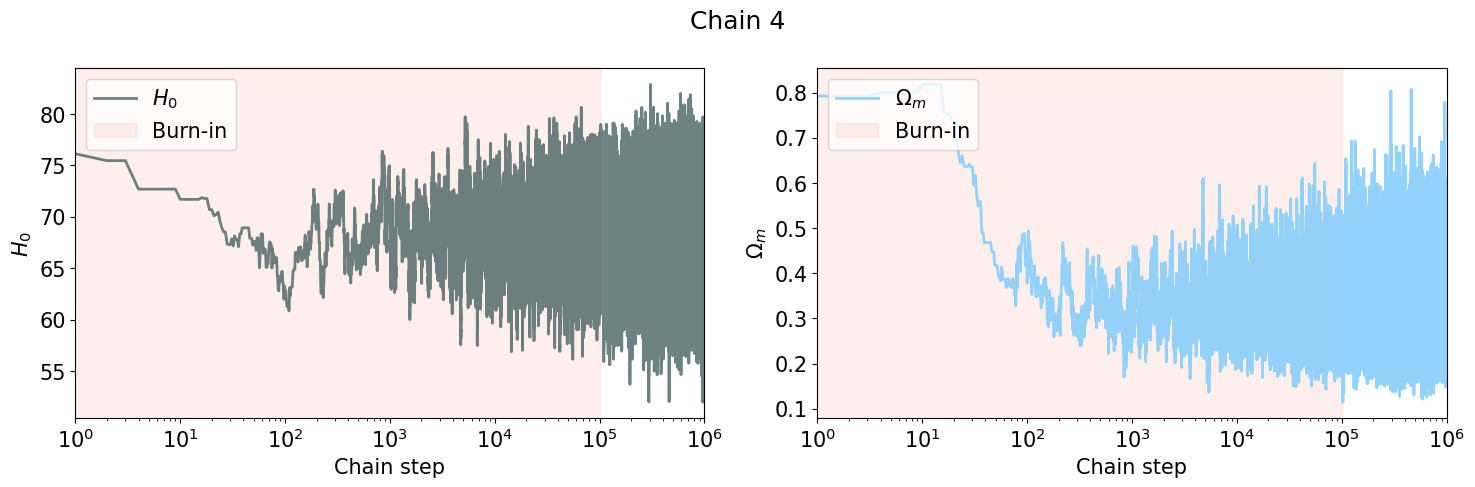

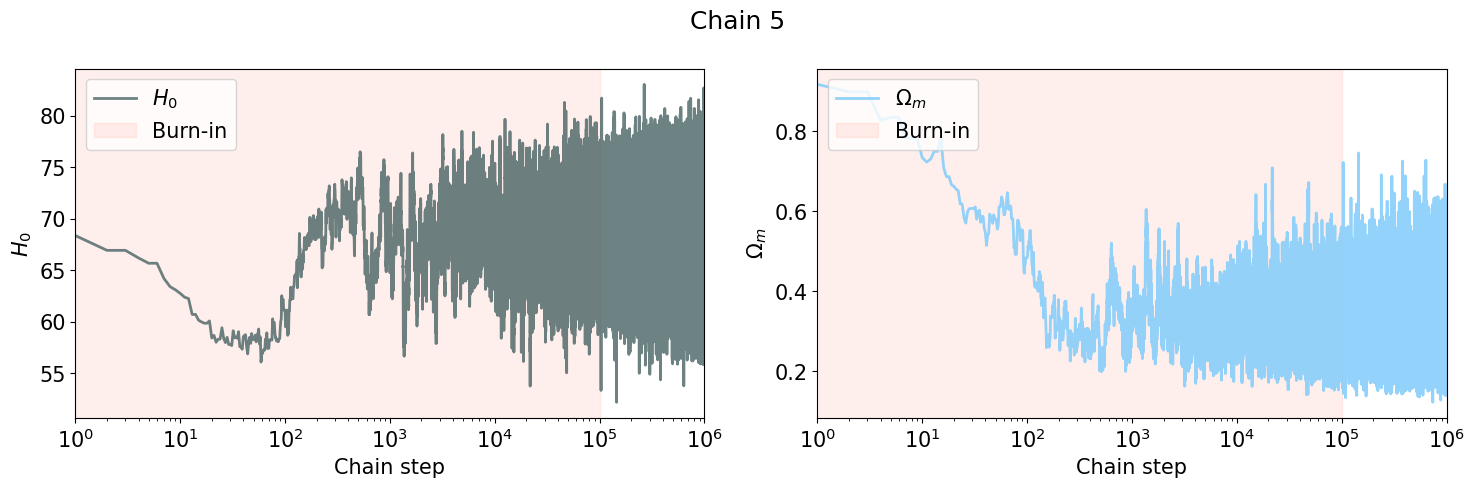

In [135]:
def plt_f(chain_no):
    # Plot each dimension of the chain
    plt.figure(figsize=(15, 5))
    plt.rcParams['text.usetex'] = False

    # Plot H0
    plt.subplot(121)
    plt.plot(mcmc_chains[chain_no][:, 0], color='darkslategrey', lw=2, alpha=0.7, label=r'$H_0$')
    plt.xlabel('Chain step')
    plt.xlim(1, 1000000)
    plt.axvspan(0, NB, color='tomato', alpha=0.1, label='Burn-in')
    plt.ylabel(r'$H_0$')
    plt.legend(loc='upper left', frameon=True)
    plt.xscale('log')

    # Plot Om (second subplot)
    plt.subplot(122)
    plt.plot(mcmc_chains[chain_no][:, 1], color='lightskyblue', lw=2, alpha=0.9, label=r'$\Omega_m$')
    plt.xlabel('Chain step')
    plt.xlim(1, 1000000)
    plt.axvspan(0, NB, color='tomato', alpha=0.1, label='Burn-in')
    plt.ylabel(r'$\Omega_m$')
    plt.legend(loc='upper left', frameon=True)
    plt.xscale('log')

    plt.suptitle(f'Chain {chain_no+1}')
    plt.tight_layout()
    plt.show()

    warnings.filterwarnings("ignore", message="findfont: Generic family 'serif' not found")

plt_f(0)
plt_f(1)
plt_f(2)
plt_f(3)
plt_f(4)

# Cut-out the burn-in regions
Chain1 = mcmc_chains[0][NB:]
Chain2 = mcmc_chains[1][NB:]
Chain3 = mcmc_chains[2][NB:]
Chain4 = mcmc_chains[3][NB:]
Chain5 = mcmc_chains[4][NB:]

H0_c1, Om_c1 = Chain1[:,0], Chain1[:,1]
H0_c2, Om_c2 = Chain2[:,0], Chain2[:,1]
H0_c3, Om_c3 = Chain3[:,0], Chain3[:,1]
H0_c4, Om_c4 = Chain4[:,0], Chain4[:,1]
H0_c5, Om_c5 = Chain5[:,0], Chain5[:,1]

### 4. Efficiency and Convergence of Chains

In [137]:
# Printing Efficiency of chains
print(f'Efficiency of Chain 1 {mcmc_chains_count_accepted[0]/float(NC)}')
print(f'Efficiency of Chain 2 {mcmc_chains_count_accepted[1]/float(NC)}')
print(f'Efficiency of Chain 3 {mcmc_chains_count_accepted[2]/float(NC)}')
print(f'Efficiency of Chain 4 {mcmc_chains_count_accepted[3]/float(NC)}')
print(f'Efficiency of Chain 5 {mcmc_chains_count_accepted[4]/float(NC)}')

Efficiency of Chain 1 0.670136
Efficiency of Chain 2 0.670348
Efficiency of Chain 3 0.669254
Efficiency of Chain 4 0.669995
Efficiency of Chain 5 0.670462


In [139]:
# Checking convergence of H0
m1 = np.mean(H0_c1,axis=0)
m2 = np.mean(H0_c2,axis=0)
m3 = np.mean(H0_c3,axis=0)
m4 = np.mean(H0_c4,axis=0)
m5 = np.mean(H0_c5,axis=0)
v1 = np.var(H0_c1,axis=0)
v2 = np.var(H0_c2,axis=0)
v3 = np.var(H0_c3,axis=0)
v4 = np.var(H0_c4,axis=0)
v5 = np.var(H0_c5,axis=0)

N = float(NB)
M = 5.
m = np.array([m1,m2,m3,m4,m5])
v = np.array([v1,v2,v3,v4,v5])
B = 1./(M-1)*((m-m.mean())*(m-m.mean())).sum()
W = 1./M*v.sum()
R = ((N-1)/N*W + B*(1+1/M))/W
print(f'H0 : R = {R} (which is < 1.03), therefore the chains have converged.')
print(f'Distribution Mean Value of parameter H0 = {m.mean()}')
print(f'Variance between chains for H0 = {B}')
print(f'Variance within chains for H0 = {W}')

H0 : R = 1.0000536023569586 (which is < 1.03), therefore the chains have converged.
Distribution Mean Value of parameter H0 = 68.4179057413383
Variance between chains for H0 = 0.0005869202356376251
Variance within chains for H0 = 11.073556334125266


In [141]:
# Checking convergence of Om
m1 = np.mean(Om_c1,axis=0)
m2 = np.mean(Om_c2,axis=0)
m3 = np.mean(Om_c3,axis=0)
m4 = np.mean(Om_c4,axis=0)
m5 = np.mean(Om_c5,axis=0)
v1 = np.var(Om_c1,axis=0)
v2 = np.var(Om_c2,axis=0)
v3 = np.var(Om_c3,axis=0)
v4 = np.var(Om_c4,axis=0)
v5 = np.var(Om_c5,axis=0)

N = float(NB)
M = 5.
m = np.array([m1,m2,m3,m4,m5])
v = np.array([v1,v2,v3,v4,v5])
B = 1./(M-1)*((m-m.mean())*(m-m.mean())).sum()
W = 1./M*v.sum()
R = ((N-1)/N*W + B*(1+1/M))/W
print(f'Om : R = {R} (which is < 1.03), therefore the chains have converged.')
print(f'Distribution Mean Value of parameter Om = {m.mean()}')
print(f'Variance between chains for Om = {B}')
print(f'Variance within chains for Om = {W}')

Om : R = 1.0000278799468958 (which is < 1.03), therefore the chains have converged.
Distribution Mean Value of parameter Om = 0.33070637885270837
Variance between chains for Om = 1.3259948203498409e-07
Variance within chains for Om = 0.00420062305997509


### 5. Density plots of the parameters & Confidence Level

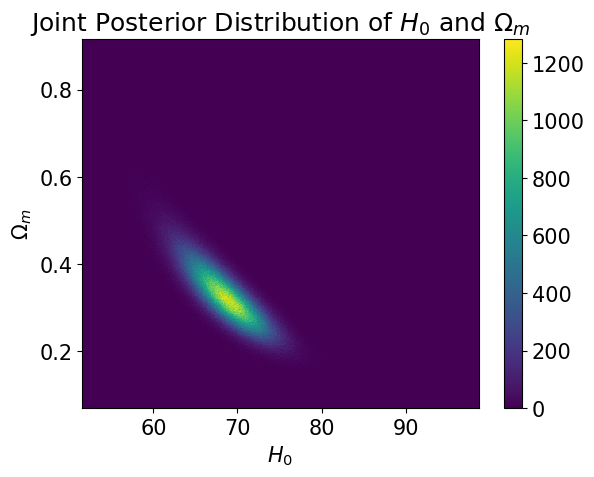

In [145]:
# concatenate all chains
all_samples = np.concatenate(mcmc_chains, axis=0)

# Extract H0 and Omega_m samples
H0_samples = all_samples[:, 0]
Omega_m_samples = all_samples[:, 1]

plt.hist2d(H0_samples, Omega_m_samples, bins=500, cmap='viridis')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$\Omega_m$')
plt.title(r'Joint Posterior Distribution of $H_0$ and $\Omega_m$')
plt.colorbar()
plt.show()

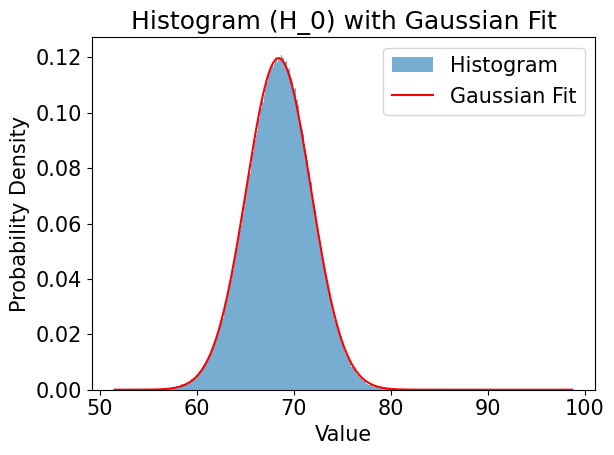

We see that the histogram of H_0 fits under a Gaussian profile


In [147]:
from scipy.stats import norm 
# Calculate the mean and standard deviation of the data
data = H0_samples
mu, std = np.mean(data), np.std(data)

# Create the histogram
plt.hist(data, bins=1000, density=True, alpha=0.6, label='Histogram')

# Create the Gaussian curve
x_axis = np.linspace(min(data), max(data), 1000)
y_axis = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, y_axis, 'r-', label='Gaussian Fit')

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram (H_0) with Gaussian Fit')
plt.legend()

plt.tight_layout()
plt.show()

print("We see that the histogram of H_0 fits under a Gaussian profile")

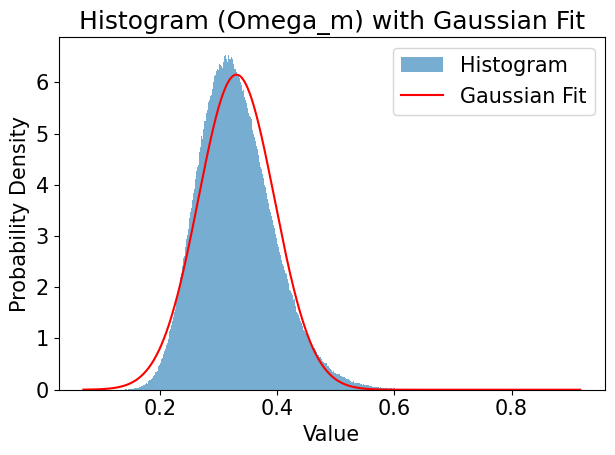

We see that the histogram of Omega_m does not fit under a Gaussian profile


In [149]:
data = Omega_m_samples
mu, std = np.mean(data), np.std(data)

# Create the histogram
plt.hist(data, bins=1000, density=True, alpha=0.6, label='Histogram')

# Create the Gaussian curve
x_axis = np.linspace(min(data), max(data), 1000)
y_axis = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, y_axis, 'r-', label='Gaussian Fit')

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram (Omega_m) with Gaussian Fit')
plt.legend()



plt.tight_layout()
plt.show()

print("We see that the histogram of Omega_m does not fit under a Gaussian profile")

In [151]:
# Sort the samples
H0_sorted = np.sort(H0_samples)
Omega_m_sorted = np.sort(Omega_m_samples)

# Calculate the 16th and 84th percentiles
H0_16th_percentile = np.percentile(H0_samples, 16)
H0_84th_percentile = np.percentile(H0_samples, 84)

Omega_m_16th_percentile = np.percentile(Omega_m_samples, 16)
Omega_m_84th_percentile = np.percentile(Omega_m_samples, 84)

# Print the confidence intervals
print("68% Confidence Interval for H0:", (H0_16th_percentile, H0_84th_percentile))
print("68% Confidence Interval for Omega_m:", (Omega_m_16th_percentile, Omega_m_84th_percentile))

68% Confidence Interval for H0: (65.12275738979314, 71.7323617357878)
68% Confidence Interval for Omega_m: (0.26759481046364697, 0.39332919447047604)


### 6. Plotting (1) with parameters drawn from posterior

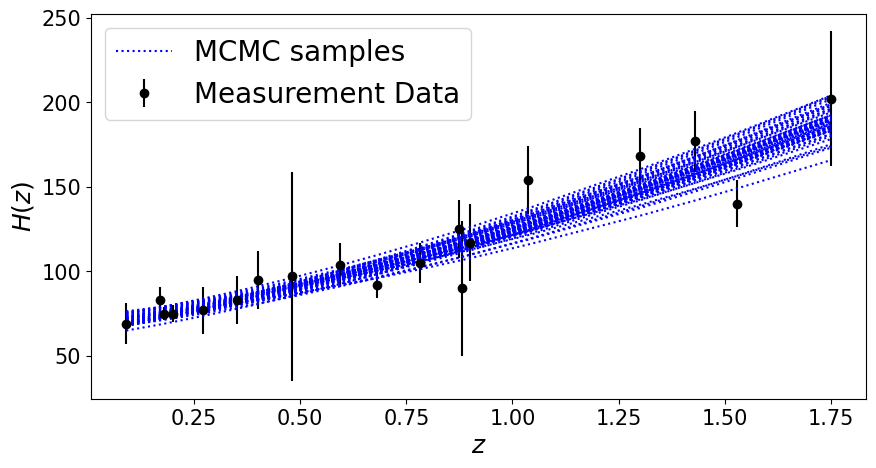

In [155]:
# Plotting the model with diff parameters
t = np.random.randint(0,len(H0_samples[:]), size=50)
plt.figure(figsize=(10,5))
plt.xlabel(r'$z$',size='large')
plt.ylabel(r'$H(z)$',size='large')
plt.errorbar(z,H,H_err,c='black',ls='',fmt='o',label='Measurement Data')
for i in t:
    plt.plot(z,H_model(z,H0_samples[i],Omega_m_samples[i]),c='blue',ls='dotted',label='MCMC samples' if i == t[0] else "")
plt.legend(fancybox=True,fontsize=20,loc=2)


### 7. Using a Gaussian prior for Omega

In [157]:
# Defining a Gaussian prior for Omega and uniform for H0
H_s1, Om_s2 = 1. , 0.01
def new_prior(theta):
    H0, Om = theta
    
    # Uniform prior for H0
    if not (50 < H0 < 100):
        return 0.0

    # Gaussian prior for Omega_m
    mean_Om = 0.315
    std_Om = 0.007
    return np.exp(-0.5 * ((Om - mean_Om) / std_Om)**2)

# Defining a Posterior
def new_posterior(theta, z, H, H_err):
    return new_prior(theta) * likelihood(theta, z, H, H_err)

def new_mcmc(): 
    chain = np.zeros((NC, 3))            # Initialize the chain, including pdf
    H1_0, Om2_0 = np.random.uniform(50,100), np.random.normal(0.315,0.007)                 # 
    initial_c = H1_0, Om2_0
    chain[0] = H1_0, Om2_0, new_posterior(initial_c, z, H, H_err)

    count_accepted = 0                   # This is to keep track of how many accepted proposals we have

    for i in range(NC-1):                         # Fill the chain with MH sampling
        xstar1, xstar2 = Proposal(chain[i,0], chain[i,1])
        runtime_c = xstar1, xstar2
        pdfStar = new_posterior(runtime_c, z, H, H_err)
        ratio =  pdfStar / chain[i,2]
        if ratio >= 1:                            # Acceptance check
            chain[i+1] = xstar1, xstar2, pdfStar
            count_accepted += 1
        elif ratio > np.random.random():
            chain[i+1] = xstar1, xstar2, pdfStar
            count_accepted += 1
        else:
            chain[i+1] = chain[i]

    return chain, count_accepted

new_mcmc_chains = []
new_mcmc_chains_count_accepted = []

for i in range(5):
    chain, count_accepted = new_mcmc()
    new_mcmc_chains.append(chain)
    new_mcmc_chains_count_accepted.append(count_accepted)


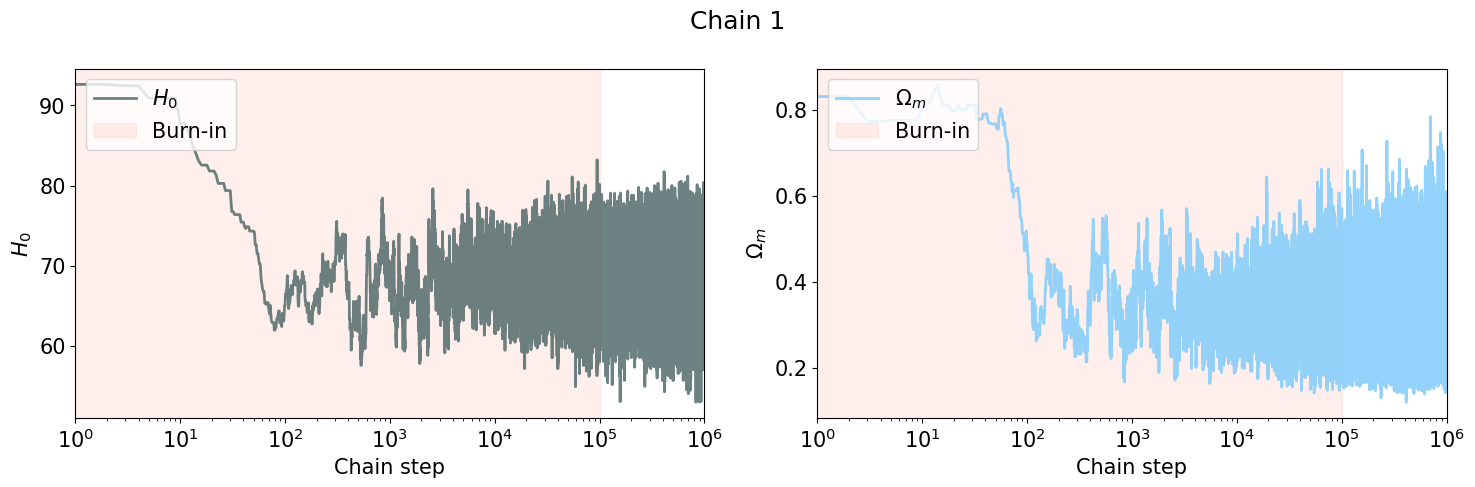

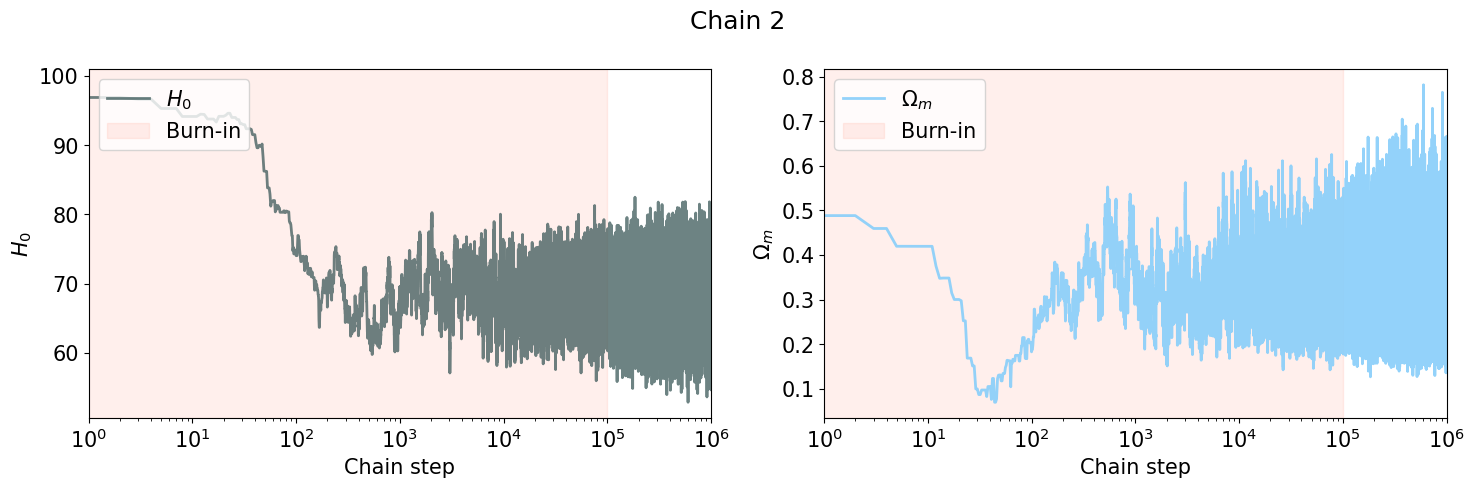

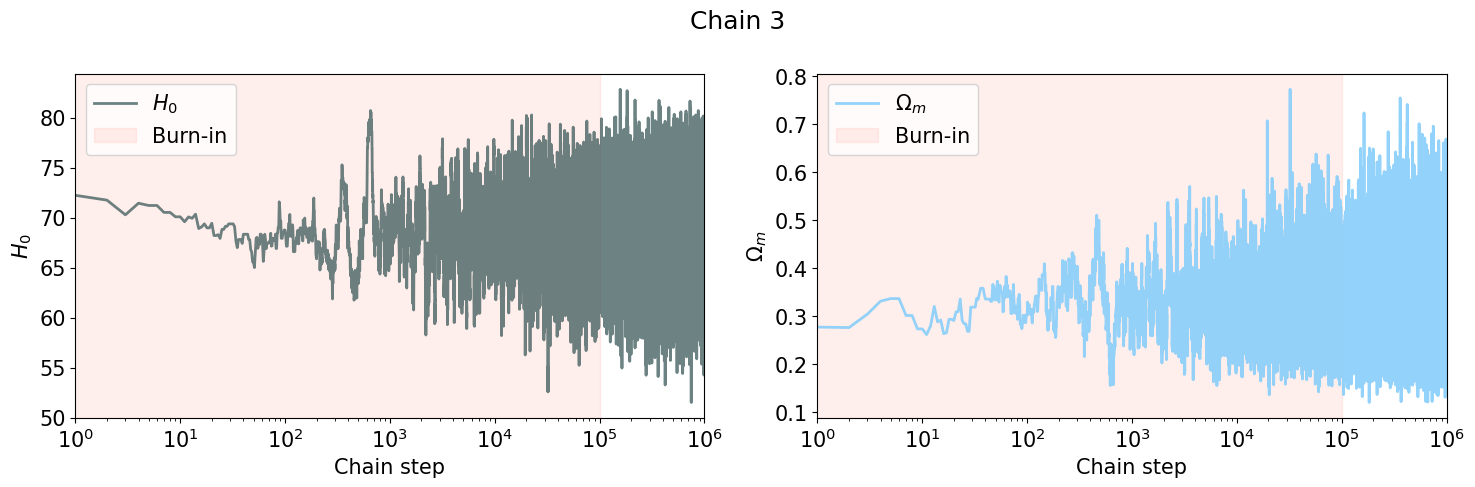

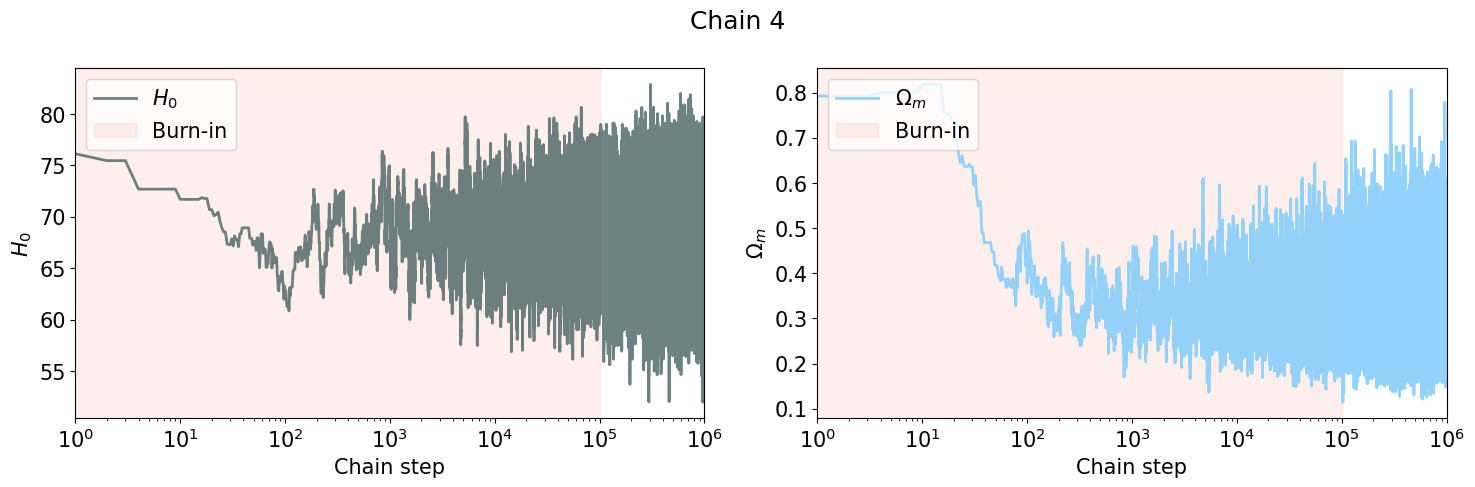

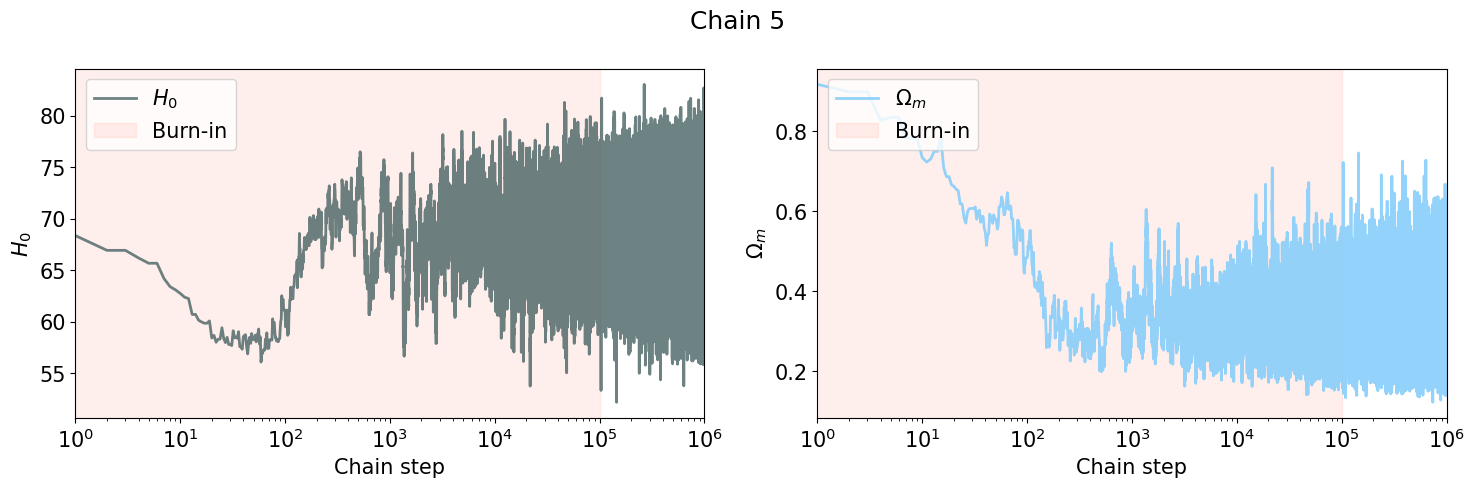

In [159]:
plt_f(0)
plt_f(1)
plt_f(2)
plt_f(3)
plt_f(4)

# Cut-out the burn-in regions
Chain1 = new_mcmc_chains[0][NB:]
Chain2 = new_mcmc_chains[1][NB:]
Chain3 = new_mcmc_chains[2][NB:]
Chain4 = new_mcmc_chains[3][NB:]
Chain5 = new_mcmc_chains[4][NB:]

H0_c1, Om_c1 = Chain1[:,0], Chain1[:,1]
H0_c2, Om_c2 = Chain2[:,0], Chain2[:,1]
H0_c3, Om_c3 = Chain3[:,0], Chain3[:,1]
H0_c4, Om_c4 = Chain4[:,0], Chain4[:,1]
H0_c5, Om_c5 = Chain5[:,0], Chain5[:,1]

In [161]:
# Printing Efficiency of chains
print(f'Efficiency of Chain 1 {new_mcmc_chains_count_accepted[0]/float(NC)}')
print(f'Efficiency of Chain 2 {new_mcmc_chains_count_accepted[1]/float(NC)}')
print(f'Efficiency of Chain 3 {new_mcmc_chains_count_accepted[2]/float(NC)}')
print(f'Efficiency of Chain 4 {new_mcmc_chains_count_accepted[3]/float(NC)}')
print(f'Efficiency of Chain 5 {new_mcmc_chains_count_accepted[4]/float(NC)}')

Efficiency of Chain 1 0.54102
Efficiency of Chain 2 0.541452
Efficiency of Chain 3 0.541489
Efficiency of Chain 4 0.541758
Efficiency of Chain 5 0.540244


In [163]:
# Checking convergence of H0
m1 = np.mean(H0_c1,axis=0)
m2 = np.mean(H0_c2,axis=0)
m3 = np.mean(H0_c3,axis=0)
m4 = np.mean(H0_c4,axis=0)
m5 = np.mean(H0_c5,axis=0)
v1 = np.var(H0_c1,axis=0)
v2 = np.var(H0_c2,axis=0)
v3 = np.var(H0_c3,axis=0)
v4 = np.var(H0_c4,axis=0)
v5 = np.var(H0_c5,axis=0)

N = float(NB)
M = 5.
m = np.array([m1,m2,m3,m4,m5])
v = np.array([v1,v2,v3,v4,v5])
B = 1./(M-1)*((m-m.mean())*(m-m.mean())).sum()
W = 1./M*v.sum()
R = ((N-1)/N*W + B*(1+1/M))/W
print(f'H0 : R = {R} (which is < 1.03), therefore the chains have converged.')
print(f'Distribution Mean Value of parameter H0 = {m.mean()}')
print(f'Variance between chains for H0 = {B}')
print(f'Variance within chains for H0 = {W}')

H0 : R = 1.0000568710981645 (which is < 1.03), therefore the chains have converged.
Distribution Mean Value of parameter H0 = 68.968441795864
Variance between chains for H0 = 0.00017813444226137917
Variance within chains for H0 = 3.1966176207793415


In [165]:
# Checking convergence of Om
m1 = np.mean(Om_c1,axis=0)
m2 = np.mean(Om_c2,axis=0)
m3 = np.mean(Om_c3,axis=0)
m4 = np.mean(Om_c4,axis=0)
m5 = np.mean(Om_c5,axis=0)
v1 = np.var(Om_c1,axis=0)
v2 = np.var(Om_c2,axis=0)
v3 = np.var(Om_c3,axis=0)
v4 = np.var(Om_c4,axis=0)
v5 = np.var(Om_c5,axis=0)

N = float(NB)
M = 5.
m = np.array([m1,m2,m3,m4,m5])
v = np.array([v1,v2,v3,v4,v5])
B = 1./(M-1)*((m-m.mean())*(m-m.mean())).sum()
W = 1./M*v.sum()
R = ((N-1)/N*W + B*(1+1/M))/W
print(f'Om : R = {R} (which is < 1.03), therefore the chains have converged.')
print(f'Distribution Mean Value of parameter Om = {m.mean()}')
print(f'Variance between chains for Om = {B}')
print(f'Variance within chains for Om = {W}')

Om : R = 0.9999968241206246 (which is < 1.03), therefore the chains have converged.
Distribution Mean Value of parameter Om = 0.3149889467177044
Variance between chains for Om = 2.7492470210569435e-10
Variance within chains for Om = 4.834463818543329e-05


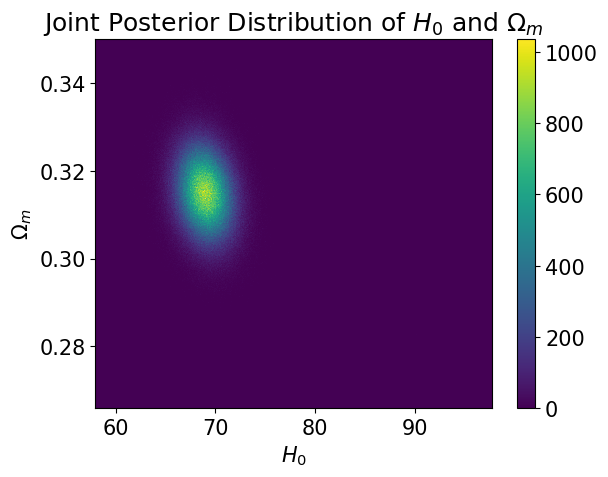

In [169]:
# concatenate all chains
all_samples = np.concatenate(new_mcmc_chains, axis=0)

# Extract H0 and Omega_m samples
H0_samples = all_samples[:, 0]
Omega_m_samples = all_samples[:, 1]

plt.hist2d(H0_samples, Omega_m_samples, bins=500, cmap='viridis')
plt.xlabel(r'$H_0$')
plt.ylabel(r'$\Omega_m$')
plt.title(r'Joint Posterior Distribution of $H_0$ and $\Omega_m$')
plt.colorbar()
plt.show()

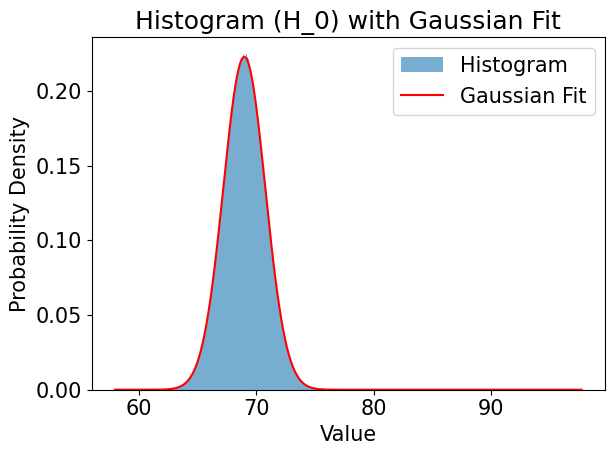

We see that the histogram of H_0 fits under a Gaussian profile


In [171]:
from scipy.stats import norm 
# Calculate the mean and standard deviation of the data
data = H0_samples
mu, std = np.mean(data), np.std(data)

# Create the histogram
plt.hist(data, bins=1000, density=True, alpha=0.6, label='Histogram')

# Create the Gaussian curve
x_axis = np.linspace(min(data), max(data), 1000)
y_axis = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, y_axis, 'r-', label='Gaussian Fit')

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram (H_0) with Gaussian Fit')
plt.legend()

plt.tight_layout()
plt.show()

print("We see that the histogram of H_0 fits under a Gaussian profile")

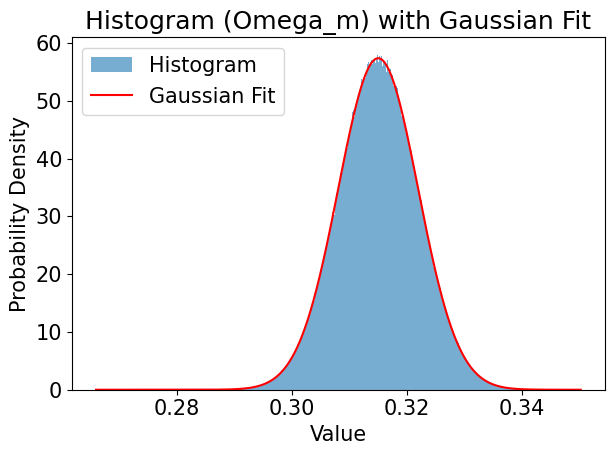

We see that the histogram of Omega_m fits under a Gaussian profile


In [175]:
data = Omega_m_samples
mu, std = np.mean(data), np.std(data)

# Create the histogram
plt.hist(data, bins=1000, density=True, alpha=0.6, label='Histogram')

# Create the Gaussian curve
x_axis = np.linspace(min(data), max(data), 1000)
y_axis = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, y_axis, 'r-', label='Gaussian Fit')

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram (Omega_m) with Gaussian Fit')
plt.legend()

plt.tight_layout()
plt.show()

print("We see that the histogram of Omega_m fits under a Gaussian profile")

In [177]:
# Sort the samples
H0_sorted = np.sort(H0_samples)
Omega_m_sorted = np.sort(Omega_m_samples)

# Calculate the 16th and 84th percentiles
H0_16th_percentile = np.percentile(H0_samples, 16)
H0_84th_percentile = np.percentile(H0_samples, 84)

Omega_m_16th_percentile = np.percentile(Omega_m_samples, 16)
Omega_m_84th_percentile = np.percentile(Omega_m_samples, 84)

# Print the confidence intervals
print("68% Confidence Interval for H0:", (H0_16th_percentile, H0_84th_percentile))
print("68% Confidence Interval for Omega_m:", (Omega_m_16th_percentile, Omega_m_84th_percentile))

68% Confidence Interval for H0: (67.19005707309526, 70.74427009938384)
68% Confidence Interval for Omega_m: (0.3080689389794121, 0.3219047127754226)


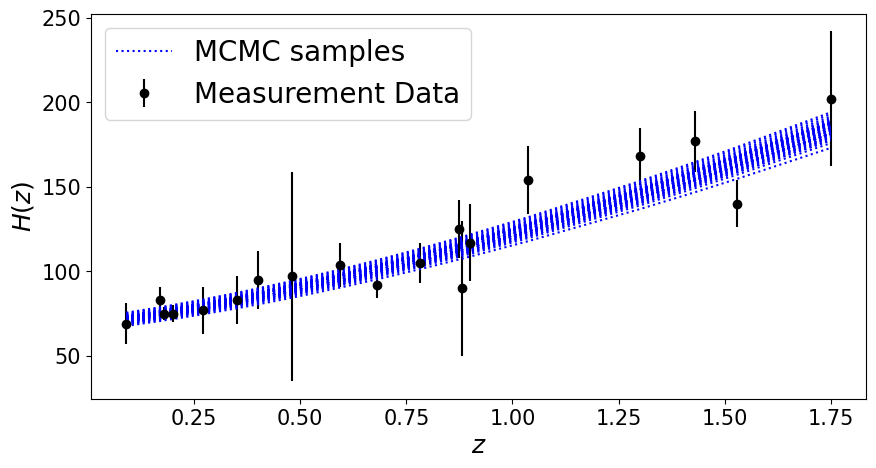

In [181]:
 #Plotting the model with diff parameters
t = np.random.randint(0,len(H0_samples[:]), size=50)
plt.figure(figsize=(10,5))
plt.xlabel(r'$z$',size='large')
plt.ylabel(r'$H(z)$',size='large')
plt.errorbar(z,H,H_err,c='black',ls='',fmt='o',label='Measurement Data')
for i in t:
    plt.plot(z,H_model(z,H0_samples[i],Omega_m_samples[i]),c='blue',ls='dotted',label='MCMC samples' if i == t[0] else "")
plt.legend(fancybox=True,fontsize=20,loc=2)

### Remarks : 
### Confidence Interval : 

### Old

### H0: (65.12275738979314, 71.7323617357878)###  Omega_m: (0.26759481046364697, 0.39332919447047604

### New 

### H0: (67.19005707309526, 70.74427009938384)###  Omega_m: (0.3080689389794121, 0.3219047127754226

### We observe that the minimum of the confidence interval has increased and the maximum has decreased for both H0 and Omega_m. This is because we have restricted the prior distribution better when using a Gaussian prior for Omega_m which decreases the spread of the distribution in the parameter space.))